In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders


2025-03-03 07:06:39.132987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 07:06:39.246098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741003599.289223    4409 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741003599.302587    4409 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 07:06:39.406632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'


In [3]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)


['test' 'train' 'val']


In [4]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
6 folder and 0 images in output/train
0 folder and 1000 images in output/train/50_new
0 folder and 1000 images in output/train/10_new
0 folder and 1000 images in output/train/200_new
0 folder and 1000 images in output/train/500_new
0 folder and 1000 images in output/train/100_new
0 folder and 1000 images in output/train/20_new
6 folder and 0 images in output/test
0 folder and 133 images in output/test/50_new
0 folder and 133 images in output/test/10_new
0 folder and 133 images in output/test/200_new
0 folder and 133 images in output/test/500_new
0 folder and 133 images in output/test/100_new
0 folder and 133 images in output/test/20_new
6 folder and 0 images in output/val
0 folder and 125 images in output/val/50_new
0 folder and 125 images in output/val/10_new
0 folder and 125 images in output/val/200_new
0 folder and 125 images in output/val/500_new
0 folder and 125 images in output/val/100_new
0 folder and 125 images in output/val/20_new


In [5]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()


Image Shape : (2048, 1536, 3)


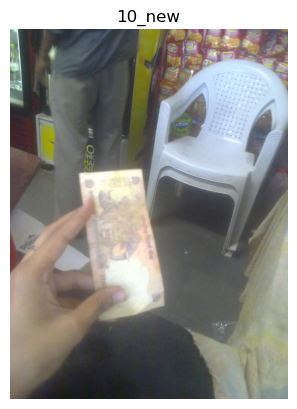

In [6]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='10_new')

In [7]:
import os
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import threading  # Used for running classification in the background

# --------------------------- #
# 🔹 Define Paths & Parameters
# --------------------------- #
train_dir = "output/train"
val_dir = "output/val"
input_shape = (224, 224, 3)
batch_size = 32
NUM_CLASSES = 6  # Updated number of classes

# Define explicit class order
classes_order = ["10_new", "20_new", "50_new", "100_new", "200_new", "500_new"]

# --------------------------- #
# 🔹 Data Preparation (for VGG16)
# --------------------------- #
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_order  # Explicit order for training
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_order  # Explicit order for validation
)

print("Training class indices:", train_data.class_indices)
print("Validation class indices:", val_data.class_indices)

# --------------------------- #
# 🔹 Function to Create VGG16 Model
# --------------------------- #
def create_vgg16_model():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pre-trained layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)  # Ensure correct number of classes

    model = Model(inputs=base_model.input, outputs=output)
    return model

# --------------------------- #
# 🔹 Train and Save VGG16 Model (if not exists)
# --------------------------- #
vgg16_model_path = "vgg16_model.h5"

if not os.path.exists(vgg16_model_path):
    print("Training VGG16 Model... 🚀")
    vgg16_model = create_vgg16_model()
    vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])
    
    vgg16_model.fit(train_data, epochs=50, validation_data=val_data)
    vgg16_model.save(vgg16_model_path)
    print(f"✅ VGG16 Model saved as '{vgg16_model_path}'.")
else:
    print(f"✅ Found existing model '{vgg16_model_path}', skipping training.")

# Load the trained model
vgg16_model = create_vgg16_model()
vgg16_model.load_weights(vgg16_model_path)
print("✅ VGG16 Model Loaded Successfully!")

# --------------------------- #
# 🔹 Function: Preprocess Image for VGG16
# --------------------------- #
def preprocess_for_vgg16(image):
    image = image.resize((224, 224))  # Resize image
    image = np.array(image) / 255.0     # Normalize
    image = np.expand_dims(image, axis=0)  # Expand dims for model
    return image

# --------------------------- #
# 🔹 Function: Classify Image Using VGG16
# --------------------------- #
def classify_image(image_path):
    image = Image.open(image_path)  # Open image
    processed_img = preprocess_for_vgg16(image)  # Preprocess for VGG16
    predictions = vgg16_model.predict(processed_img)  # Predict

    class_id = np.argmax(predictions)
    confidence = predictions[0][class_id]
    
    # Use the same explicit class order
    label = f"{classes_order[class_id]} ({confidence:.2f})"
    
    return label

# --------------------------- #
# 🔹 Function to Open File Dialog and Select Image
# --------------------------- #
def select_image():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    image_path = filedialog.askopenfilename(title="Select Image", filetypes=[
        ("Image files", "*.jpg *.jpeg *.png *.JPG *.JPEG *.PNG"), 
        ("All files", "*.*")
    ])
    return image_path

# --------------------------- #
# 🔹 Function to Display the Classification Result
# --------------------------- #
def show_classification_result(image_path):
    result_label.config(text="Processing... Please wait.", fg="black")
    
    # Run classification in a background thread to avoid blocking UI
    threading.Thread(target=run_classification, args=(image_path,)).start()

# --------------------------- #
# 🔹 Function to Run Classification in the Background
# --------------------------- #
def run_classification(image_path):
    try:
        # Classify the uploaded image
        result = classify_image(image_path)
        
        # Update the result label in the main thread
        result_label.config(text=f"Prediction: {result}", fg="green")
        
    except Exception as e:
        # In case of error, display the error message
        result_label.config(text=f"Error: {str(e)}", fg="red")

# --------------------------- #
# 🔹 Function to Load and Display Image in Tkinter
# --------------------------- #
def load_image(image_path):
    image = Image.open(image_path)
    image.thumbnail((400, 400))  # Resize for better display
    img_tk = ImageTk.PhotoImage(image)
    
    # Keep a reference of the image to prevent it from being garbage collected
    preview_label.image = img_tk  
    preview_label.config(image=img_tk)

# --------------------------- #
# 🔹 Create the Tkinter GUI
# --------------------------- #
window = tk.Tk()
window.title("Image Classification")
window.geometry("600x600")

# Create an upload button
upload_button = tk.Button(window, text="Upload Image", font=("Helvetica", 14), command=lambda: on_upload())
upload_button.pack(pady=10)

# Label to display the selected image preview
preview_label = tk.Label(window)
preview_label.pack(pady=20)

# Label for the classification result
result_label = tk.Label(window, text="Prediction: None", font=("Helvetica", 14), fg="blue")
result_label.pack(pady=20)

# --------------------------- #
# 🔹 Upload Button Logic
# --------------------------- #
def on_upload():
    image_path = select_image()
    if image_path:
        load_image(image_path)
        show_classification_result(image_path)
    else:
        messagebox.showerror("Error", "No image selected. Please upload an image.")

# Run the Tkinter event loop
window.mainloop()


Found 6000 images belonging to 6 classes.
Found 750 images belonging to 6 classes.
Training class indices: {'10_new': 0, '20_new': 1, '50_new': 2, '100_new': 3, '200_new': 4, '500_new': 5}
Validation class indices: {'10_new': 0, '20_new': 1, '50_new': 2, '100_new': 3, '200_new': 4, '500_new': 5}
Training VGG16 Model... 🚀


2025-03-03 07:08:56.553596: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.2342 - loss: 1.8201 - val_accuracy: 0.4813 - val_loss: 1.4912
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 859s 5s/step - accuracy: 0.4474 - loss: 1.4595 - val_accuracy: 0.6093 - val_loss: 1.2497
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 856s 5s/step - accuracy: 0.5495 - loss: 1.2525 - val_accuracy: 0.6760 - val_loss: 1.0543
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - accuracy: 0.5878 - loss: 1.1123 - val_accuracy: 0.7333 - val_loss: 0.8964
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 851s 5s/step - accuracy: 0.6274 - loss: 1.0179 - val_accuracy: 0.7267 - val_loss: 0.8190
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 856s 5s/step - accuracy: 0.6730 - loss: 0.9078 - val_accuracy: 0.7773 - val_loss: 0.6907
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.7038 - loss: 0.8437 - val_accuracy: 0.7947 - val_loss: 0.6335
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 853s 5s/step - accuracy: 0.7219 - loss: 0.8099 - val_accu

✅ VGG16 Model saved as 'vgg16_model.h5'.
✅ VGG16 Model Loaded Successfully!


In [8]:
  from tensorflow.keras.models import load_model

# Load the model
model = load_model("vgg16_model.h5")

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,560 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

In [9]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

✅ VGG16 Model Loaded Successfully!
Found 750 images belonging to 6 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step
Classification Report:
               precision    recall  f1-score   support

      10_new       0.93      0.92      0.93       125
      20_new       0.95      0.98      0.96       125
      50_new       0.98      0.98      0.98       125
     100_new       0.98      0.97      0.98       125
     200_new       0.92      0.97      0.94       125
     500_new       0.97      0.93      0.95       125

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



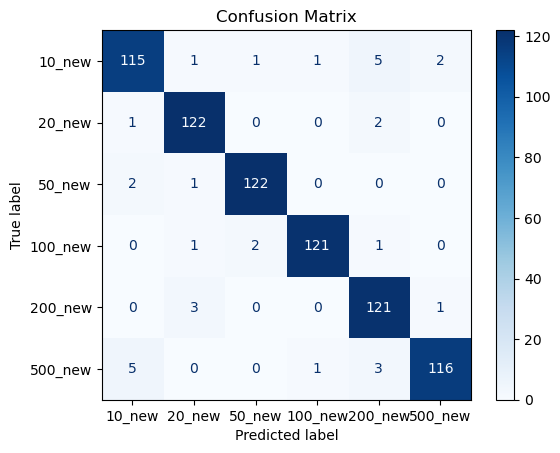

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# --------------------------- #
# Define Paths & Parameters
# --------------------------- #
train_dir = "output/train"
val_dir = "output/val"
input_shape = (224, 224, 3)
batch_size = 32
NUM_CLASSES = 6  # Updated number of classes
classes_order = ["10_new", "20_new", "50_new", "100_new", "200_new", "500_new"]

# --------------------------- #
# Define function to create VGG16 model architecture
# --------------------------- #
def create_vgg16_model():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pre-trained layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# --------------------------- #
# Load Pre-trained Model
# --------------------------- #
vgg16_model_path = "vgg16_model.h5"

# Create model architecture and load weights
vgg16_model = create_vgg16_model()
vgg16_model.load_weights(vgg16_model_path)
print("✅ VGG16 Model Loaded Successfully!")

# --------------------------- #
# Create Data Generators
# --------------------------- #
# Define ImageDataGenerator for validation (rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the validation data generator with shuffle disabled
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes_order,
    shuffle=False  # Important to align predictions with true labels
)

# --------------------------- #
# Generate Classification Report
# --------------------------- #
# Get true labels from the generator
true_labels = val_data.classes

# Get predictions from the model
predictions = vgg16_model.predict(val_data)
predicted_labels = np.argmax(predictions, axis=1)

# Create class names in the correct order (sorted by index)
class_names = [k for k, v in sorted(val_data.class_indices.items(), key=lambda item: item[1])]

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

# (Optional) Plot a confusion matrix for additional visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
